# Итоговый проект по первому модулю "Основы анализа данных"

## Введение

На основе статистических данных по продажам компьютерных игр для интернет-магазина «Стримчик» необходимо провести исследование закономерностей, определяющих успешность игры с целью определения потенциально популярного продукта для дальнейших рекламных компаний в 2017 году.

## Основные задачи 

В задачи исследования входит:
- определение структуры общемировых продаж игр по разным годам с определением платформ игр, которые в 2017 году могут принести большую прибыль;
- определить структуру продаж наиболее успешных платформ, выявить, насколько равномерными являются их продажи;
- выявить наличие связи между рейтингами пользователей/критиков и общими продажами, а также определить наиболее кассовые жанры игр по общемировым продажам;
- определить какие платформы и жанры игр были популярны в разных частях мира, включая Северную Америку, Европу и Японию;
- определить какие по ESRB рейтингу игры в разных странах являются более успешными - проверить гипотезы о равенстве пользовательских рейтингов на (1) разных платформах и (2) игр с разными активными жанрами.

## Загрузка необходимых библиотек и данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
df = pd.read_csv('/datasets/games.csv')

## Основная информация о данных

Выведем основную информацию о датафрейме.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Познакомимся с записями в строках.

In [4]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Обратим внимание на количество явных дубликатов.

In [5]:
df.duplicated().sum()

0

Сделаем красивыми названия столбцов, приведем все к нижнему регистру.

In [6]:
df = df.rename(columns={
    'Name':'name', 
    'Platform':'platform', 
    'Year_of_Release':'year_of_release',
    'Genre':'genre',
    'NA_sales':'na_sales',
    'EU_sales':'eu_sales',
    'JP_sales':'jp_sales',
    'Other_sales':'other_sales',
    'Critic_Score':'critic_score',
    'User_Score':'user_score',
    'Rating':'rating'
})

##  Обработка пропусков

Займемся обработкой пропусков, сначала посмотрим, сколько вообще их во всем датафрейме.

In [7]:
df.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Пропуски в столбце 'name' удалю, так как здесь не указаны важнейшие параметры, необходимые для анализа,
также этих пропуска всего 2.

In [8]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Ниже операция удаления.

In [9]:
df = df.loc[~(df['name'].isna())]

Посмотрим на пропуски в столбце 'year_of_release', их всего 269, поэтому удалим их.

In [10]:
df[df['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [11]:
df = df.loc[~(df['year_of_release'].isna())]

Теперь, когда пропусков нет, можно перевести данные столбца 'year_of_release' в int.

In [12]:
df['year_of_release'] = df['year_of_release'].astype('int')

Займемся пропусками в столбцах 'critic_score', 'user_score'.
С первого взгляда можно выдвинуть гипотезу, что составители датафрейма халатно отнеслись к информации, связанной с 
рейтингами игр, так как количество пропусков в этих столбцах совпадает.
Выведем срез, где все значения в 'critic_score', 'user_score' пропущены.

In [13]:
df[(df['critic_score'].isna()) & (df['user_score'].isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Учитывая то, (1) что в датафрейме существует всего 6500+ строк, где одновременно пропущены значения в столбцах 'critic_score', 
'user_score', а также то (2), что в каждом из этих столбцов по отдельности примерно такое же количество пропусков, можно сделать вывод, что к заполнению именно этих вместе взятых столбцов подходили не очень строго. Но у меня есть еще одна гипотеза, что рейтинговая информация не была добавлена в таблицу для игр 2016 года выпуска. Проверим это в след ячейке.

In [14]:
df.loc[(df['critic_score'].isna()) & (df['user_score'].isna()) & (df['year_of_release']==2016)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
108,Pokemon Sun/Moon,3DS,2016,Role-Playing,2.98,1.45,2.26,0.45,NaN,NaN,NaN
1216,Ratchet & Clank (2016),PS4,2016,Platform,0.50,0.76,0.04,0.24,NaN,NaN,NaN
1275,Doom (2016),PS4,2016,Shooter,0.54,0.69,0.02,0.24,NaN,NaN,NaN
1466,Yokai Watch 3,3DS,2016,Action,0.00,0.00,1.33,0.00,NaN,NaN,NaN
1475,The Elder Scrolls V: Skyrim,PS4,2016,Role-Playing,0.48,0.59,0.04,0.21,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16699,The Longest 5 Minutes,PSV,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN


Но из следующего среза датафрейма видим, что в строках с 2016 годом мало пропусков. Моя гипотеза не подтвердилась.
Но есть еще одна, что рейтинговая информация не доступна для старых игр. Проверим это далее.

In [15]:
df.loc[(df['critic_score'].isna()) & (df['user_score'].isna()) & (df['year_of_release'] < 2000)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
12,Pokemon Gold/Pokemon Silver,GB,1999,Role-Playing,9.00,6.18,7.20,0.71,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16341,Builder's Block,PS,1999,Strategy,0.01,0.00,0.00,0.00,NaN,NaN,NaN
16468,Meru Purana,PS,1996,Strategy,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16607,Samurai Shodown: Warrios Rage,PS,1999,Fighting,0.01,0.00,0.00,0.00,NaN,NaN,NaN
16666,Psychic Detective,PS,1995,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Не самая большая доля пропусков в строках, где год меньше 2000.

In [16]:
df.loc[(df['critic_score'].isna()) & (df['user_score'].isna()) & (df['year_of_release'] > 2010)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN
72,Minecraft,X360,2013,Misc,5.70,2.65,0.02,0.81,NaN,NaN,NaN
83,Pokemon Black 2/Pokemon White 2,DS,2012,Role-Playing,2.79,1.72,3.14,0.41,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN


Попусков много и в строках где год превышает даже 2010, уж тогда-то точно уже задумывались о всевозможных рейтингах.
На основании всего этого, я делаю вывод о том, что пропуски в столбцах 'critic_score', 'user_score', не связаны никак
с какими-то временными периодами, а, скорее всего, информацию просто не предоставляли. Ну что ж, оставим пропуски в покое, 
так как их много, не будем их удалять.

Теперь займемся пропусками в столбце 'rating'. Согласно информации в интернете, этот рейтинг присваивается играм, выпускаемым в Америке и США. Получается, что игры остальной части света, которых в датасете много, имеют в этой графе NaN. Чтобы в дальнейшнем при анализе учитывать этот фактор, присвоим пропускам в данной графе значение 'unknown'.

In [17]:
df['rating'] = df['rating'].fillna(value='unknown')

**Вывод после этапа обработки пропусков данных**
<br> Анализ данных позволил удалить пропуски в столбцах 'name' и 'year_of_release', и это определенно меньше общепринятых 10% от общих данных.</br>

## Поиск аномальных значений и неявных дубликатов

В данном разделе проверим диапазоны значений для числовых данных, а также просто корректность некторых данных для строковых.

In [18]:
df['platform'].sort_values().unique()

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

Здесь, вроде, все адекватные значения, все платформы существуют.

In [19]:
df['year_of_release'].sort_values().unique()

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016])

С годами все хорошо.

In [20]:
df['genre'].sort_values().unique()

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'], dtype=object)

И здесь неявных дубликатов нет.

Поищем выбивающиеся значения в столбцах, связанных с продажами.

In [21]:
df['na_sales'].min(), df['na_sales'].max(),\
df['eu_sales'].min(), df['eu_sales'].max(),\
df['jp_sales'].min(), df['jp_sales'].max()

(0.0, 41.36, 0.0, 28.96, 0.0, 10.22)

Есть строки, где продажи равнялись 0, но это может быть связано с тем, что игра выходила только в одной из частей света, т.е. продажи не велись в других странах. Странно будет, если окажется, что информация о продажах отсутствует во всех столбцах (выручка равна 0). Проверим это.

In [22]:
df.loc[(df['na_sales']==0) & (df['eu_sales']==0) & (df['jp_sales']==0) & (df['other_sales']==0)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16676,G1 Jockey 4 2008,PS3,2008,Sports,0.0,0.0,0.0,0.0,NaN,NaN,unknown
16709,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.0,0.0,0.0,0.0,NaN,NaN,unknown


А вот и две строки, которые, по всей видимости можно удалить, так как по ним нет никакой коммерческой информации. 
Мы занимаемся анализом данных в первую очередь для того, чтобы быть полезными заказчикам. А с этими строками каши не сваришь. Удаляю.

In [23]:
df = df.loc[~((df['na_sales']==0) & (df['eu_sales']==0) & (df['jp_sales']==0) & (df['other_sales']==0))]

Продолжаем дальше изучать значения столбцов.

In [24]:
df['critic_score'].sort_values().unique()

array([13., 17., 19., 20., 21., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
       70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82.,
       83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.,
       96., 97., 98., nan])

Здесь все хорошо. Критики, по всей видимости, оценивали игру от 0 до 100.

In [25]:
df['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

Пользователи оценивали игры по 10-балльной шкале. И видно, что есть некоторое значение 'tbd'.
Что бы это могло значить? Интрнет говорит - "to be determined". Цитата из интернет-источника "Очень часто подобное 
сокращение можно встретить в анонсах компьютерных игр в графе "Дата выхода". Можно предположить, что эта аббревиатура
должна быть в ячейках с самыми свежими играми - 2016 года. Смысл в том, что юзеры еще не определили их рейтинг.
Возможно, рейтинг еще не сформировался из-за того, что мало пользователей сыграло в игру.

In [26]:
df[df['user_score']=='tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


Но мои предположения не подтвердились. Видим, что значение 'tbd' в самых разных строках, где год принимает разные значения. Из среза данных видно, что где-то 'tbd' указано в строках с высокими продажами и довольно 'старыми' датами, 
то есть рейтинг пользователей должен был сформироваться. А где-то, как в самом конце таблицы, рейтинг у игр не сформировался,
так как копий было продано всего около 10000. И это звучит логично. Получается природа 'tbd' в таблице двойственна, 
с одной стороны, логично отсутствие информации, так как игры были неуспешные и рейтинг не сформировался. Но с другой стороны,
в успешных играх тоже есть значения 'tbd', что говорит о том, что данную информацию просто нам не предоставили.
Оставим 'tbd', удаление строк с этим параметром исказит наши выводы.

Чтобы перевести формат 'user_score' во float для начала нужно как-то разобраться с 'tbd'. Сделаем из этого значение NaN.

In [27]:
df.loc[df['user_score']=='tbd', 'user_score'] = None

In [28]:
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8459
user_score         8979
rating                0
dtype: int64

Мы видим, что после этой операции количество пропусков в 'user_score' и 'critic_score' стало примерно одиковым.
На мой взгляд, это неплохо.

Теперь меняем формат столбца 'user_score':

In [29]:
df['user_score'] = df['user_score'].astype('float')

In [30]:
df['rating'].sort_values().unique()

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', 'unknown'],
      dtype=object)

Здесь со значениями тоже все хорошо.

## Добавление вспомогательных столбцов

Создадим столбец с суммарными продажами по всему миру.

In [31]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

Обнулим индексы.

In [32]:
df.reset_index(drop=True, inplace=True)

Посмотрим, что у нас осталось.

In [33]:
temp = df.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16442 entries, 0 to 16441
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16442 non-null  object 
 1   platform         16442 non-null  object 
 2   year_of_release  16442 non-null  int64  
 3   genre            16442 non-null  object 
 4   na_sales         16442 non-null  float64
 5   eu_sales         16442 non-null  float64
 6   jp_sales         16442 non-null  float64
 7   other_sales      16442 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16442 non-null  object 
 11  total_sales      16442 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.5+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

## Исследовательский анализ данных

Посмотрим на динамику выхода игр за все года.

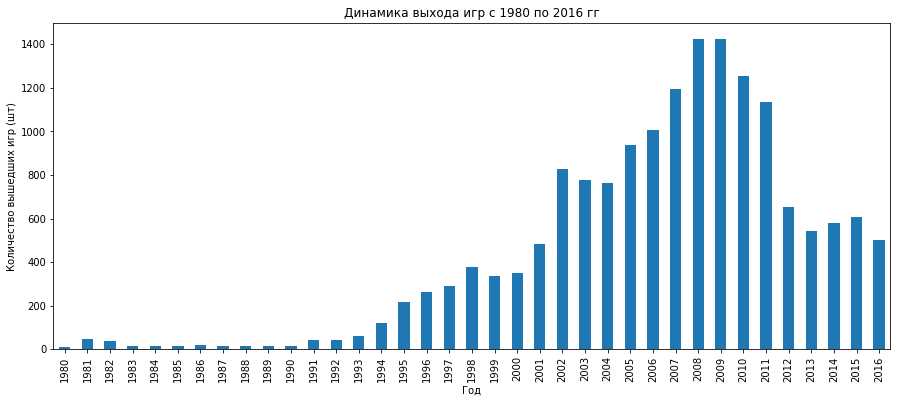

In [34]:
df.groupby('year_of_release')['total_sales'].count().plot(kind='bar', figsize=(15, 6))
plt.xlabel('Год')
plt.ylabel('Количество вышедших игр (шт)')
plt.title('Динамика выхода игр с 1980 по 2016 гг')
plt.show()

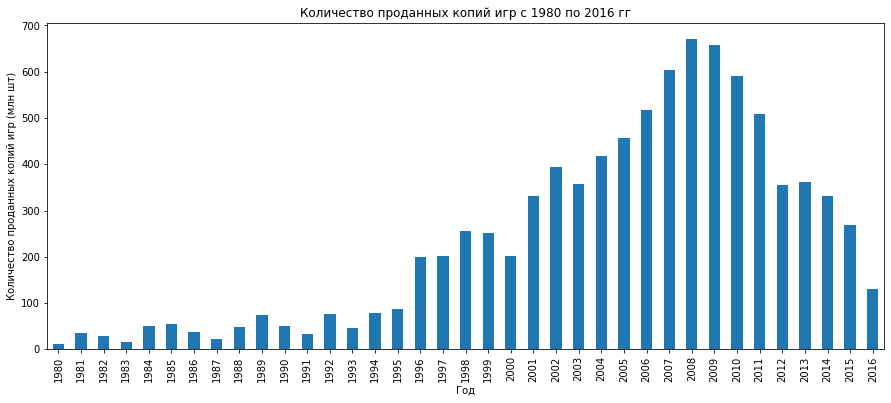

In [35]:
df.groupby('year_of_release')['total_sales'].sum().plot(kind='bar', figsize=(15, 6))
plt.xlabel('Год')
plt.ylabel('Количество проданных копий игр (млн шт)')
plt.title('Количество проданных копий игр с 1980 по 2016 гг')
plt.show()

**Вывод** 
<br>
Видим, что рисунок двух выше приведенных графиков совпадает. И это достаточно логичная зависимость. Начиная с 1980 года количество выпускаемых игр увеличивалось, поэтому росло и число проданных копий.
<br>
Однако мы видим, что в 2008-2009 годах оба иллюстрируемых показателя достигли своего пика, а затем начали снижаться. То есть от тренда роста выпуска игр и продаж, мы перешли к тренду снижения.

Теперь глянем, как менялись продажи по платформам за разные годы.

In [36]:
pd.set_option('display.max_columns', None)
pd.pivot_table(df, index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').fillna('')

platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1980,11.38,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1981,35.68,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1982,28.88,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1983,5.84,,,,,,,,,,,10.96,,,,,,,,,,,,,,,,,,,
1984,0.27,,,,,,,,,,,50.08,,,,,,,,,,,,,,,,,,,
1985,0.45,,,,0.02,,,,,,,53.44,,0.04,,,,,,,,,,,,,,,,,
1986,0.67,,,,,,,,,,,36.41,,,,,,,,,,,,,,,,,,,
1987,1.94,,,,,,,,,,,19.76,,,,,,,,,,,,,,,,,,,
1988,0.74,,,,,1.43,,,,,,45.01,,0.03,,,,,,,,,,,,,,,,,


Таблица показывает также, что платформы в среднем остаются актуальными около 10 лет (исключение PC, логично). Также можно заметить, что за последние годы наибольшими суммарными продажами обладают платформы PS4, XOne, 3DS. 

Выбросим лишнее из таблицы. Нам нужны будут только данные 2014 - 2016 гг, так как бизнес чаще всего имеет дело с периодом в 3 года. Также в этих годах появились новые платформы, ставшие лидерами по продажам.

In [37]:
df = df[df['year_of_release']>2013]

Посмотрим, как сводная таблица выглядит теперь.

In [38]:
pd.pivot_table(df, index='platform', columns='year_of_release', values='total_sales', aggfunc='sum').fillna('')

year_of_release,2014,2015,2016
platform,,,
3DS,43.76,27.78,15.14
PC,13.28,8.52,5.25
PS3,47.76,16.82,3.6
PS4,100.00,118.90,69.25
PSP,0.24,0.12,
PSV,11.90,6.25,4.25
Wii,3.75,1.14,0.18
WiiU,22.03,16.35,4.6
X360,34.74,11.96,1.52


Провизуализируем таблицу.

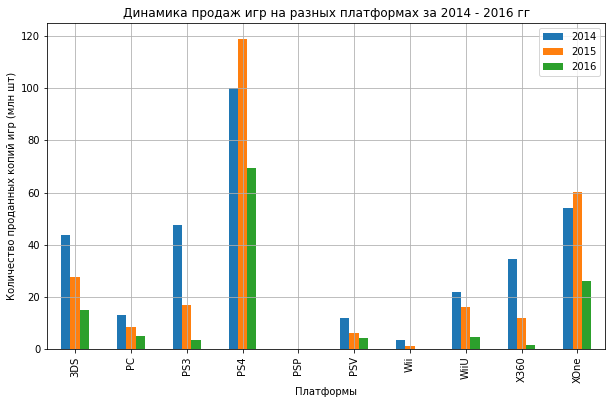

In [39]:
pd.pivot_table(df, index='platform', columns='year_of_release', values='total_sales', aggfunc='sum').\
plot(kind='bar', figsize=(10, 6), grid=True)
plt.xlabel('Платформы')
plt.ylabel('Количество проданных копий игр (млн шт)')
plt.title('Динамика продаж игр на разных платформах за 2014 - 2016 гг')
plt.legend(['2014', '2015', '2016'])
plt.show()

**Вывод:**
<br> В качестве актуального стоит выбрать период, охватывающий 2014 - 2016 гг, что связано с тем, что сфера компьютерных игр является очень динамичной и быстро развивающейся. Кроме того, для этого времени характерно появление новых платформ, доля которых на рынке стала доминировать.
<br>
В актуальном периоде можно выделить следующие платформы, продажи которых увеличивались от года к году: PS4 и ХOne.
<br>
Платформы, продажи на которых также являются значительными по объему, но их продажи несколько упали: PS3, 3DS, X360 и WiiU.

Посмотрим на показатели общих продаж всех игр на отдельных крупных и потенциально прибыльных платформах. Сколько в среднем на той или другой платформе продается копий одной игры? Для этого построим ящики с усами.

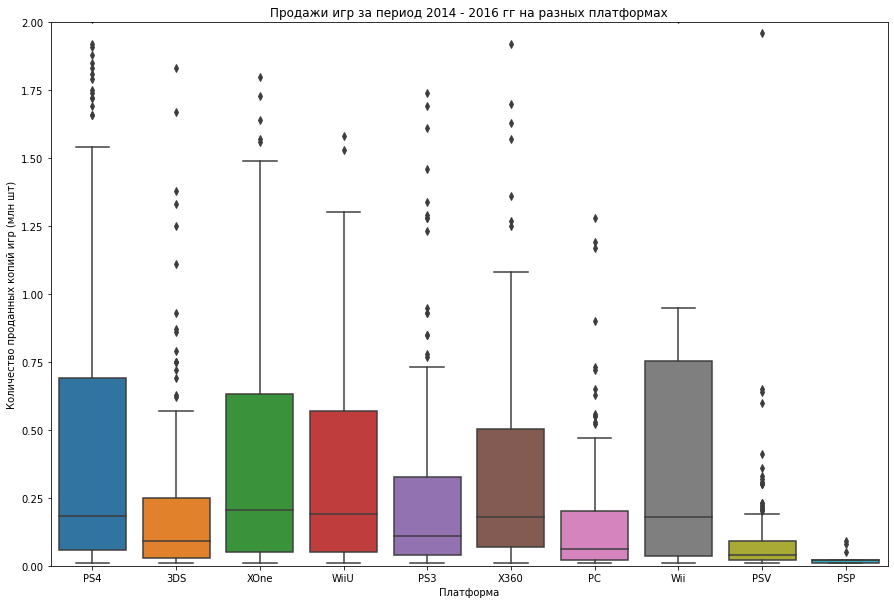

In [40]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='platform', y='total_sales', data=df)
plt.ylabel('Количество проданных копий игр (млн шт)')
plt.ylim(0, 2)
plt.xlabel('Платформа')
plt.title('Продажи игр за период 2014 - 2016 гг на разных платформах')

plt.show()

Узнаем, сколько всего игр внутри каждой платформы, чтобы судить о представительности статистики.

In [41]:
df.groupby('platform')['name'].count()

platform
3DS     212
PC      151
PS3     219
PS4     376
PSP      13
PSV     295
Wii      11
WiiU     73
X360    111
XOne    228
Name: name, dtype: int64

**Вывод**
<br>
Статистический анализ продаж игр внутри разных платформ показал интересные результаты. Казалось бы, что есть платформы с большим количеством общих продаж игр. Однако диаграмма размаха показывает, что эти значительные продажи делаются за счет очень коммерчески успешных игр, которые с точки зрения статистики, скорее, относятся к выбросам, нежели к математически ожидаемым величинам. Так, например, медианные значения продаж приблизительно равны друг другу на следующих платформах - PS4, XOne, WiiU, X360, Wii. Но в тоже время Wii можно не рассматривать, так как для данной платформы слишком мало данных (11 наблюдений).

Посмотрим на то, как внутри 5 успешных платформ отзывы критиков и пользователей влияют на продажи. Эти платформы мы выявили на предыдущем этапе анализа по медианных продажам - PS4, XOne, WiiU, X360 и PS3. Построим для этого графики рассеяния и посчитаем корреляции.

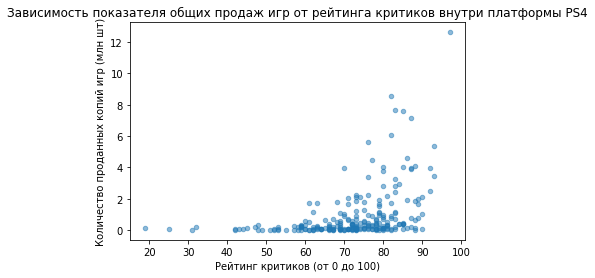

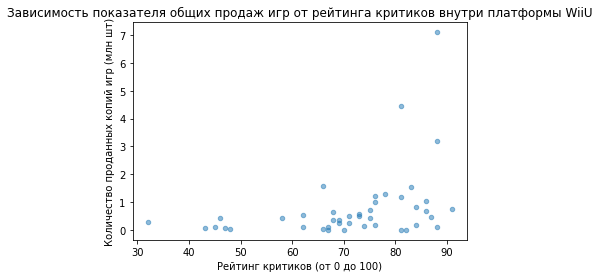

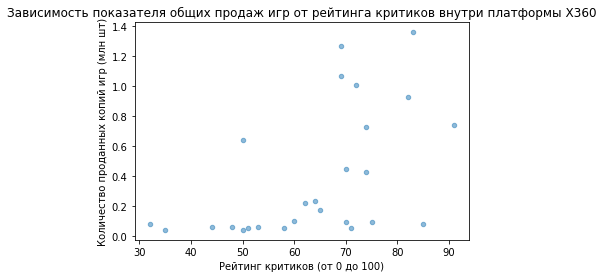

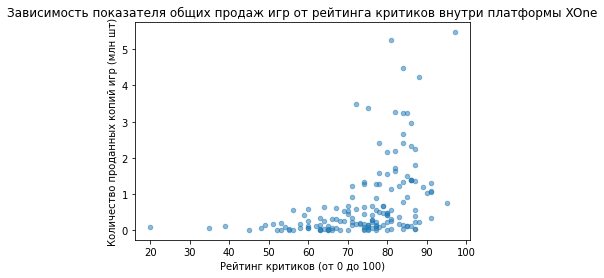

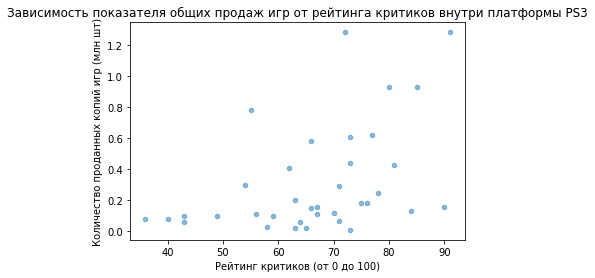

In [42]:
df_ps4 = df.loc[df['platform']=='PS4']
df_ps4.plot(kind='scatter', x='critic_score', y='total_sales', alpha=0.5)
plt.xlabel('Рейтинг критиков (от 0 до 100)')
plt.ylabel('Количество проданных копий игр (млн шт)')
plt.title('Зависимость показателя общих продаж игр от рейтинга критиков внутри платформы PS4')
plt.show()

df_wiiu = df.loc[df['platform']=='WiiU']
df_wiiu.plot(kind='scatter', x='critic_score', y='total_sales', alpha=0.5)
plt.xlabel('Рейтинг критиков (от 0 до 100)')
plt.ylabel('Количество проданных копий игр (млн шт)')
plt.title('Зависимость показателя общих продаж игр от рейтинга критиков внутри платформы WiiU')
plt.show()

df_x360 = df.loc[df['platform']=='X360']
df_x360.plot(kind='scatter', x='critic_score', y='total_sales', alpha=0.5)
plt.xlabel('Рейтинг критиков (от 0 до 100)')
plt.ylabel('Количество проданных копий игр (млн шт)')
plt.title('Зависимость показателя общих продаж игр от рейтинга критиков внутри платформы X360')
plt.show()

df_xone = df.loc[df['platform']=='XOne']
df_xone.plot(kind='scatter', x='critic_score', y='total_sales', alpha=0.5)
plt.xlabel('Рейтинг критиков (от 0 до 100)')
plt.ylabel('Количество проданных копий игр (млн шт)')
plt.title('Зависимость показателя общих продаж игр от рейтинга критиков внутри платформы XOne')
plt.show()

df_ps3 = df.loc[df['platform']=='PS3']
df_ps3.plot(kind='scatter', x='critic_score', y='total_sales', alpha=0.5)
plt.xlabel('Рейтинг критиков (от 0 до 100)')
plt.ylabel('Количество проданных копий игр (млн шт)')
plt.title('Зависимость показателя общих продаж игр от рейтинга критиков внутри платформы PS3')
plt.show()

In [43]:
df_ps4['total_sales'].corr(df_ps4['critic_score']).round(2),\
df_wiiu['total_sales'].corr(df_wiiu['critic_score']).round(2),\
df_x360['total_sales'].corr(df_x360['critic_score']).round(2),\
df_xone['total_sales'].corr(df_xone['critic_score']).round(2),\
df_ps3['total_sales'].corr(df_ps3['critic_score']).round(2)

(0.4, 0.37, 0.53, 0.43, 0.45)

**Вывод**
<br>
Диаграммы рассеяния вместе с коэффициентами корреляции свидетельствуют о том, что между количеством продаж и оценкой критиков существует прямая слабая связь. Это может говорить, о том, что положительные отзывы критиков все же влияют на коммерческий успех игры.

Теперь определим если связь между отзывами пользователей и числом продаж.

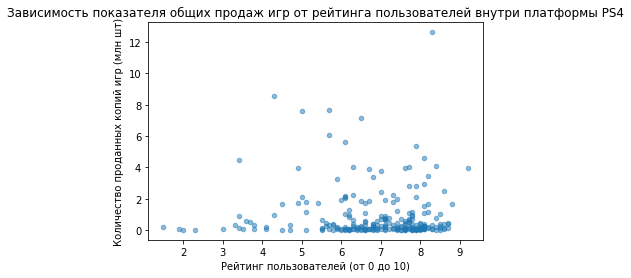

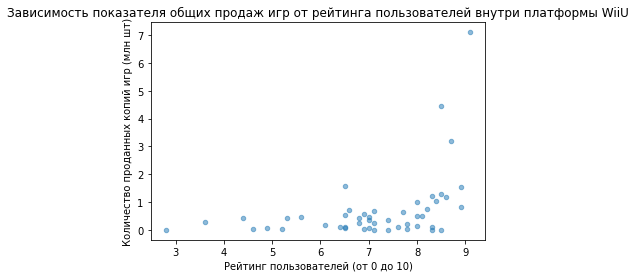

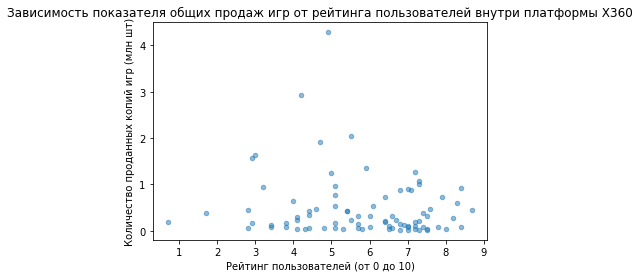

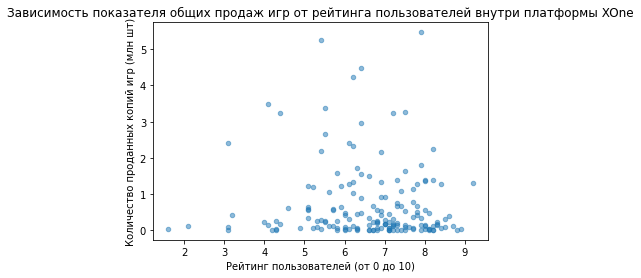

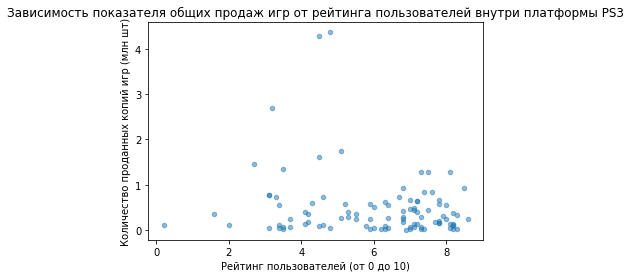

In [44]:
df_ps4.plot(kind='scatter', x='user_score', y='total_sales', alpha=0.5)
plt.xlabel('Рейтинг пользователей (от 0 до 10)')
plt.ylabel('Количество проданных копий игр (млн шт)')
plt.title('Зависимость показателя общих продаж игр от рейтинга пользователей внутри платформы PS4')
plt.show()

df_wiiu.plot(kind='scatter', x='user_score', y='total_sales', alpha=0.5)
plt.xlabel('Рейтинг пользователей (от 0 до 10)')
plt.ylabel('Количество проданных копий игр (млн шт)')
plt.title('Зависимость показателя общих продаж игр от рейтинга пользователей внутри платформы WiiU')
plt.show()

df_x360.plot(kind='scatter', x='user_score', y='total_sales', alpha=0.5)
plt.xlabel('Рейтинг пользователей (от 0 до 10)')
plt.ylabel('Количество проданных копий игр (млн шт)')
plt.title('Зависимость показателя общих продаж игр от рейтинга пользователей внутри платформы X360')
plt.show()

df_xone.plot(kind='scatter', x='user_score', y='total_sales', alpha=0.5)
plt.xlabel('Рейтинг пользователей (от 0 до 10)')
plt.ylabel('Количество проданных копий игр (млн шт)')
plt.title('Зависимость показателя общих продаж игр от рейтинга пользователей внутри платформы XOne')
plt.show()

df_ps3.plot(kind='scatter', x='user_score', y='total_sales', alpha=0.5)
plt.xlabel('Рейтинг пользователей (от 0 до 10)')
plt.ylabel('Количество проданных копий игр (млн шт)')
plt.title('Зависимость показателя общих продаж игр от рейтинга пользователей внутри платформы PS3')
plt.show()

In [45]:
df_ps4['total_sales'].corr(df_ps4['user_score']).round(2),\
df_wiiu['total_sales'].corr(df_wiiu['user_score']).round(2),\
df_x360['total_sales'].corr(df_x360['user_score']).round(2),\
df_xone['total_sales'].corr(df_xone['user_score']).round(2),\
df_ps3['total_sales'].corr(df_ps3['user_score']).round(2)

(-0.04, 0.41, -0.14, -0.07, -0.17)

**Вывод**
<br>
Диаграммы рассеяния вместе с коэффициентами корреляции свидетельствуют о том, что между количеством продаж и оценкой пользователей не существует какой-либо связи, что говорит о том, что рейтинг пользователей не влияет на продажи игр. Исключением является лишь платформа WiiU, здесь связь прямая, но слабая. Возможно, отзывы пользователей на этой платформе все же сказываются на продажах.

Исследуем успешность игровых жанров. Можно выдвинуть следующую гипотезу - существуют жанры игр, которые больше пользуются
популярностью у пользователей, и, соответственно, являются более прибыльными. Посмотрим сначала на суммарные продажи по жанрам. 

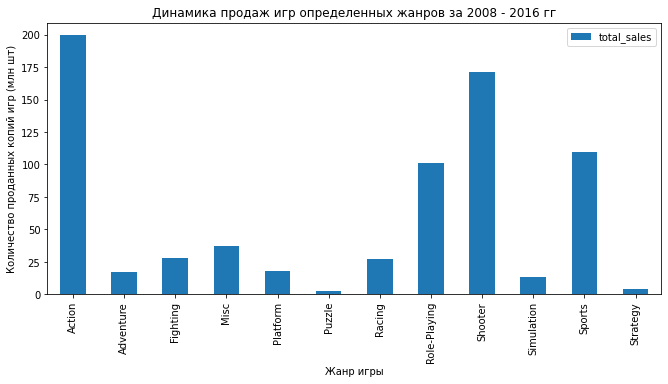

In [46]:
pd.pivot_table(df, index='genre', values='total_sales', aggfunc='sum').plot(kind='bar', figsize=(11, 5))
plt.xlabel('Жанр игры')
plt.ylabel('Количество проданных копий игр (млн шт)')
plt.title('Динамика продаж игр определенных жанров за 2008 - 2016 гг')
plt.show()

Здесь все по классике. Впереди всех экшн и стрелялки.Самый популярный жанр - action. Затем идут shooter, sport и role-playing.
Самые малопродаваемые жанры - strategy, adventures, puzzle. Но может оказаться так, что наиболее продаваемыми были какие-то определенные игры, которые и вносили искажение в статистику. Надо посмотреть на диаграммы размаха.

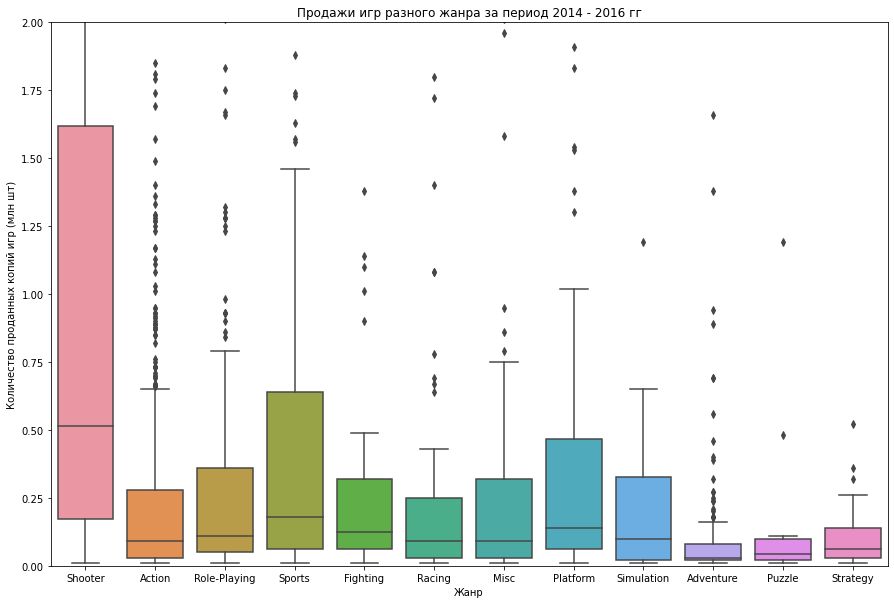

In [47]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='genre', y='total_sales', data=df)
plt.ylabel('Количество проданных копий игр (млн шт)')
plt.ylim(0, 2)
plt.xlabel('Жанр')
plt.title('Продажи игр разного жанра за период 2014 - 2016 гг')

plt.show()

**Вывод**
<br>По медианному показателю продаж одной игры ситуация меняется. На самом деле, больше всего в среднем продаются игры жанра Shooter, Sports, а затем уже Action. И вообще, согласно средним показателям, между играми нет такого колоссального разрыва в продажах. На последнем месте игры жанра Adventure, а не Puuzle, как это видно по столбчатой диаграмме.

## Составление портрета пользователя каждого региона

Посмотрим какие платформы были популярны в разных частях мира в 2014 - 2016 гг. 

In [48]:
df.groupby('platform')['na_sales'].sum().sort_values(ascending=False)

platform
PS4     98.61
XOne    81.27
X360    28.30
3DS     22.64
PS3     22.05
WiiU    19.36
PC       7.23
PSV      2.52
Wii      2.08
PSP      0.00
Name: na_sales, dtype: float64

In [49]:
df.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)

platform
PS4     130.04
XOne     46.25
PS3      25.54
PC       17.97
3DS      16.12
X360     15.49
WiiU     13.15
PSV       3.53
Wii       2.59
PSP       0.00
Name: eu_sales, dtype: float64

In [50]:
df.groupby('platform')['jp_sales'].sum().sort_values(ascending=False)

platform
3DS     44.24
PS4     15.02
PSV     14.54
PS3     11.22
WiiU     7.31
PSP      0.36
XOne     0.32
X360     0.08
PC       0.00
Wii      0.00
Name: jp_sales, dtype: float64

Для визуализации выделим топ-5, а остальные объединим в other.

In [51]:
# Для Северной Америки
na_platform = df.groupby('platform')['na_sales'].sum().sort_values(ascending=False)
na_platform = na_platform.to_frame()
na_platform = na_platform.T
na_platform['other'] = na_platform[['WiiU','PC','PSV','Wii','PSP']].sum(axis = 1)
na_platform = na_platform.drop(columns=['WiiU','PC','PSV','Wii','PSP'])
na_platform = na_platform.T
na_platform = na_platform.squeeze()

# Для Европы
eu_platform = df.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)
eu_platform = eu_platform.to_frame()
eu_platform = eu_platform.T
eu_platform['other'] = eu_platform[['X360', 'WiiU','PSV','Wii','PSP']].sum(axis = 1)
eu_platform = eu_platform.drop(columns=['X360', 'WiiU','PSV','Wii','PSP'])
eu_platform = eu_platform.T
eu_platform = eu_platform.squeeze()

# Для Японии
jp_platform = df.groupby('platform')['jp_sales'].sum().sort_values(ascending=False)
jp_platform = jp_platform.to_frame()
jp_platform = jp_platform.T
jp_platform['other'] = jp_platform[['PSP', 'XOne','X360','PC','Wii']].sum(axis = 1)
jp_platform = jp_platform.drop(columns=['PSP', 'XOne','X360','PC','Wii'])
jp_platform = jp_platform.T
jp_platform = jp_platform.squeeze()

Визуализируем данные.

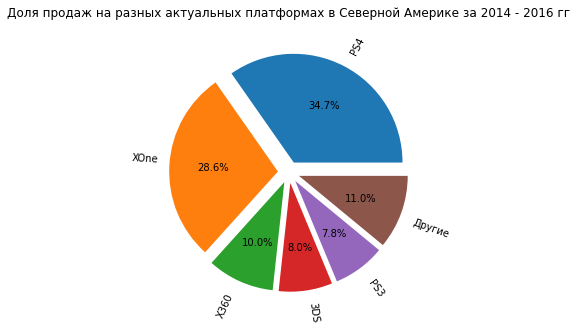

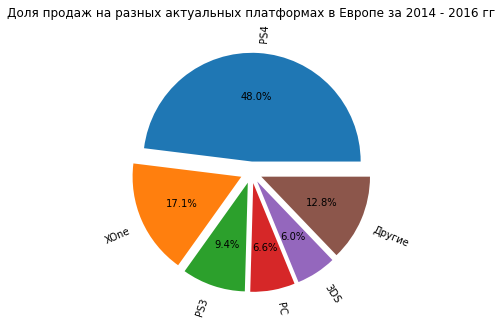

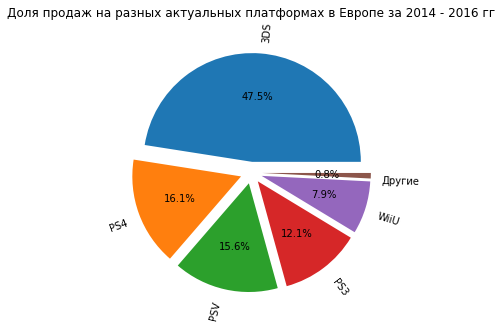

In [52]:
# Для Америки:
fig, ax = plt.subplots()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
ax.pie(na_platform, autopct='%1.1f%%', explode=explode, \
       labels=['PS4', 'XOne', 'X360', '3DS', 'PS3', 'Другие'], rotatelabels=True)
ax.set_title(label='Доля продаж на разных актуальных платформах в Северной Америке за 2014 - 2016 гг', pad = 20)
fig.set_figheight(5)
fig.set_figwidth(5)
plt.show()

# Для Европы:
fig, ax = plt.subplots()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
ax.pie(eu_platform, autopct='%1.1f%%', explode=explode, \
       labels=['PS4', 'XOne', 'PS3', 'PC', '3DS', 'Другие'], rotatelabels=True)
ax.set_title(label='Доля продаж на разных актуальных платформах в Европе за 2014 - 2016 гг', pad = 20)
fig.set_figheight(5)
fig.set_figwidth(5)
plt.show()

# Для Японии:
fig, ax = plt.subplots()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
ax.pie(jp_platform, autopct='%1.1f%%', explode=explode, \
       labels=['3DS', 'PS4', 'PSV', 'PS3', 'WiiU', 'Другие'], rotatelabels=True)
ax.set_title(label='Доля продаж на разных актуальных платформах в Европе за 2014 - 2016 гг', pad = 20)
fig.set_figheight(5)
fig.set_figwidth(5)
plt.show()

**Вывод**
<br>
Круговые диаграммы показывают, что в Северной Америке и Европе по продажам лидируют PS4 и XOne. Следует отметить, что в случае Европы доля PS4 на рынке почти 50%.
<br>
Совсем другая ситуация в Японии. Здесь лидером рынка (доля почти 50%) является платформа 3DS, за ней уже расположились PS4, PSV, PS3. XOne в Японии вовсе не популярна и занимает одно из последних мест.


Теперь посмотрим какие были самые популярные жанры в разных частях света за 2014 - 2016 гг.

In [53]:
df.groupby('genre')['na_sales'].sum().sort_values(ascending=False)

genre
Shooter         79.02
Action          72.53
Sports          46.13
Role-Playing    33.47
Misc            15.05
Fighting        12.43
Racing           8.74
Platform         6.79
Adventure        5.64
Simulation       2.63
Strategy         0.98
Puzzle           0.65
Name: na_sales, dtype: float64

In [54]:
df.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)

genre
Action          74.68
Shooter         65.52
Sports          45.73
Role-Playing    28.17
Racing          14.13
Misc            12.86
Simulation       7.30
Platform         6.80
Fighting         6.69
Adventure        6.49
Strategy         1.79
Puzzle           0.52
Name: eu_sales, dtype: float64

In [55]:
df.groupby('genre')['jp_sales'].sum().sort_values(ascending=False)

genre
Role-Playing    31.16
Action          29.58
Fighting         6.37
Misc             5.61
Shooter          4.87
Adventure        3.60
Sports           3.26
Platform         2.69
Simulation       2.31
Racing           1.76
Strategy         0.95
Puzzle           0.93
Name: jp_sales, dtype: float64

Для визуализации выделим топ-5, а остальные объединим в other.

In [56]:
# Для Северной Америки
na_genre = df.groupby('genre')['na_sales'].sum().sort_values(ascending=False)
na_genre = na_genre.to_frame()
na_genre = na_genre.T
na_genre['other'] = na_genre[['Adventure','Sports','Platform','Simulation','Racing', 'Strategy', 'Puzzle']].sum(axis = 1)
na_genre = na_genre.drop(columns=['Adventure','Sports','Platform','Simulation','Racing', 'Strategy', 'Puzzle'])
na_genre = na_genre.T
na_genre = na_genre.squeeze()

# Для Европы
eu_genre = df.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)
eu_genre = eu_genre.to_frame()
eu_genre = eu_genre.T
eu_genre['other'] = eu_genre[['Misc', 'Simulation','Platform','Fighting','Adventure', 'Strategy', 'Puzzle']].sum(axis = 1)
eu_genre = eu_genre.drop(columns=['Misc', 'Simulation','Platform','Fighting','Adventure', 'Strategy', 'Puzzle'])
eu_genre = eu_genre.T
eu_genre = eu_genre.squeeze()

# Для Японии
jp_genre = df.groupby('genre')['jp_sales'].sum().sort_values(ascending=False)
jp_genre = jp_genre.to_frame()
jp_genre = jp_genre.T
jp_genre['other'] = jp_genre[['Adventure', 'Sports','Platform','Simulation','Racing', 'Strategy', 'Puzzle']].sum(axis = 1)
jp_genre = jp_genre.drop(columns=['Adventure', 'Sports','Platform','Simulation','Racing', 'Strategy', 'Puzzle'])
jp_genre = jp_genre.T
jp_genre = jp_genre.squeeze()

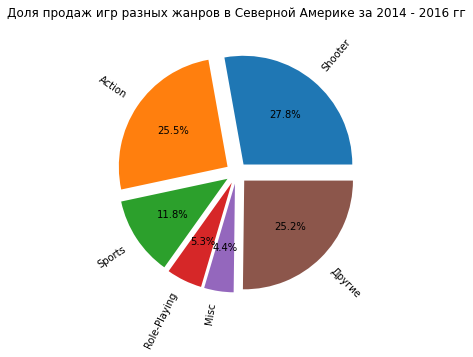

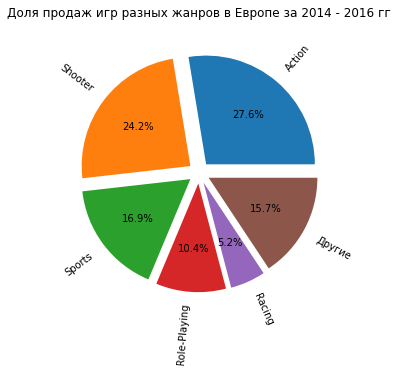

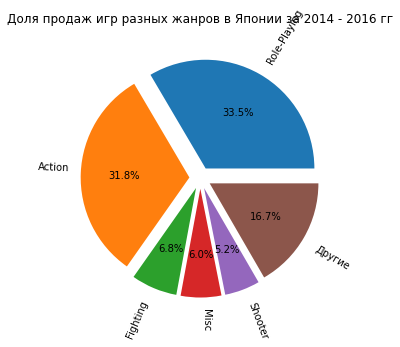

In [57]:
# Для Америки:
fig, ax = plt.subplots()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
ax.pie(na_genre, autopct='%1.1f%%', explode=explode, \
       labels=['Shooter', 'Action', 'Sports', 'Role-Playing', 'Misc', 'Другие'], rotatelabels=True)
ax.set_title(label='Доля продаж игр разных жанров в Северной Америке за 2014 - 2016 гг', pad = 20)
fig.set_figheight(5)
fig.set_figwidth(5)
plt.show()

# Для Европы:
fig, ax = plt.subplots()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
ax.pie(eu_genre, autopct='%1.1f%%', explode=explode, \
       labels=['Action', 'Shooter', 'Sports', 'Role-Playing', 'Racing', 'Другие'], rotatelabels=True)
ax.set_title(label='Доля продаж игр разных жанров в Европе за 2014 - 2016 гг', pad = 20)
fig.set_figheight(5)
fig.set_figwidth(5)
plt.show()

# Для Японии:
fig, ax = plt.subplots()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
ax.pie(jp_genre, autopct='%1.1f%%', explode=explode, \
       labels=['Role-Playing', 'Action', 'Fighting', 'Misc', 'Shooter', 'Другие'], rotatelabels=True)
ax.set_title(label='Доля продаж игр разных жанров в Японии за 2014 - 2016 гг', pad = 20)
fig.set_figheight(5)
fig.set_figwidth(5)
plt.show()

**Вывод:** 
<br>Анализ продаж игр разных жанров в разных частях мира показывает, что предпочтения геймеров в Северной Америке и Европе схожи. Они и диктуют общемировой тренд, который был ранее замечен на общих продажах. Здесь в лидерах action, shooter и sports. Другая ситуация в Японии. Здесь на первом месте ролевые игры, а уже потом экшн.

Посмотрим на то, как продаются в разных частях света игры с разным рейтингом ESRB.

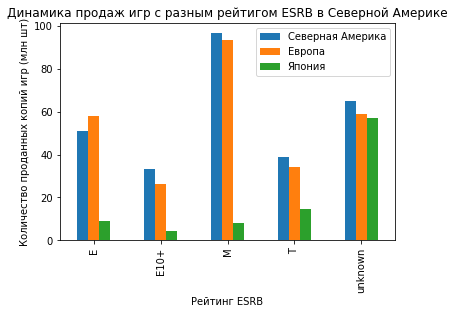

In [58]:
# Посмотрим на то, как продаются в разных частях света
df.groupby('rating')['na_sales', 'eu_sales', 'jp_sales'].sum().plot(kind='bar')
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Количество проданных копий игр (млн шт)')
plt.title('Динамика продаж игр c разным рейтигом ESRB в Северной Америке')
plt.legend(['Северная Америка', 'Европа', 'Япония'])
plt.show()

**Вывод:** 
<br>В Америке и Европе лидером по продажам являются игры с рейтингом 'для всех'. Но лишь ненамного отстают в этих частях мира игры с неизвестным рейтингом. Игры с этим рейтингом лидируют по продажам в Японии. На втором месте в Японии игры с рейтингом 'для всех'.

## Проверка гипотез

Проверка гипотезы: средние рейтинги пользователей платформ XOne и PC одинаковые:

```
H_0: Средний рейтинг пользователей платформы XOne = среднему рейтингу платформы PC
H_a: Средний рейтинг пользователей платформы XOne ≠ среднему рейтингу платформы PC
alpha = 0.05, критический уровень зададим таким
```

По сути, нужно проверить гипотезу о равенстве средних двух выборок, которые не зависят друг от друга.
Применим t-тест.

In [61]:
results = st.ttest_ind(
    df[df['platform']=='XOne']['user_score'],
    df[df['platform']=='PC']['user_score'], equal_var=False, nan_policy='omit') # я предполагаю, что дисперсии у этих 
                                # двух параметров не равны друг другу, также установим, чтобы в рассчет не шли значения NaN
alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.11601398086668943
Не получилось отвергнуть нулевую гипотезу


Посмотрим, какие средние рейтиги пользователей платформ, чтобы подкрепить вывод, данный тестом Стьдента.

In [62]:
df.groupby('platform')['user_score'].mean()

platform
3DS     7.138182
PC      6.298361
PS3     6.014286
PS4     6.828099
PSP          NaN
PSV     7.656164
Wii     6.350000
WiiU    7.087500
X360    5.771084
XOne    6.594545
Name: user_score, dtype: float64

Действительно можно утверждать, что рейтинги платформ XOne и PC близки. Тогда как, рейтинги 3DS и X360 явно разные.

Проверка гипотезы: средние пользовательские рейтинги жанров action и sports разные:

```
H_0: Средний рейтинг пользователей жанра action = среднему рейтингу жанра sports
H_a: Средний рейтинг пользователей жанра action ≠ среднему рейтингу жанра sports
alpha = 0.05, критический уровень зададим таким
```

Применим тот же самый тест, что и выше. 

In [63]:
results = st.ttest_ind(
    df[df['genre']=='Action']['user_score'],
    df[df['genre']=='Sports']['user_score'], equal_var=False, nan_policy='omit') # я предполагаю, что дисперсии у этих 
                                                                                # двух параметров разные
alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

1.182555038264477e-14
Отвергаем нулевую гипотезу


In [64]:
df.groupby('genre')['user_score'].mean()

genre
Action          6.760606
Adventure       7.470213
Fighting        6.983784
Misc            6.968293
Platform        6.741379
Puzzle          7.975000
Racing          6.327451
Role-Playing    7.348571
Shooter         6.549074
Simulation      6.504167
Sports          5.225197
Strategy        7.216667
Name: user_score, dtype: float64

Таблица средних пользовательских рейтингов игр разного жанра действительно показывает, что оценки Action и Sports разные. А вот Fighting и Misc очень близки друг другу.

**Вывод по проверке гипотез**
<br> 
Для проверки гипотез, связанных со сравнением пользовательских рейтингов разных платформ и разных жанров игр, изначально необходимо исходить из логики, что пользовательские рейтинги равны, это и будет нулевой гипотезой. Противоположное утверждение - альтернативная гипотеза. 
Для проверки равенства двух средних выборок, которые независимы друг от друга, необходимо использовать двусторонний тест Стьюдента.
<br>
Тест показал, (1) что пользовательские рейтинги платформ XOne и PC равны, (2) пользовательские рейтинги игр с жанрами 'Action' и 'Sports' разные.

##  Заключение

**Основная задача проекта**

С целью определения закономерностей компьютерных игр, способствующих получению большей прибыли в 2017 году, для онлайн-магазина "Стримчик" был проведен исследовательский анализ данных.

**Материалы для анализа**

Материалом для исследования послужили данные о числе проданных игр разных платформ, рейтингов и жанров.

**Охватываемый период исследования**

Анализируем период - 2014 - 2016 гг. Это связано с тем, что сфера компьютерных игр является очень динамичной и быстро развивающейся. Кроме того, для этого времени характерно появление новых платформ, доля которых на рынке стала доминировать.

**Основные выводы**

Анализ общих продаж на платформах показал, что наиболее успешными были платформы PS4 и ХOne. Однако анализ медианных значений продаж игр на разных платформах, свидетельствует о том, что в среднем продажи на PS4 и XOne не отличаются от продаж на WiiU, X360.

Данные о корреляции данных отзывов критиков и общих продаж свидетельствуют о том, что положительные отзывы критиков все же влияют на коммерческий успех игры.

Не смотря на то, что по общему числу проданных копий лидируют игры жанра action, по медианному показателю продаж игр ситуация меняется. Можно утверждать, что больше всего в среднем продаются игры жанра shooter, sports, а затем уже action.

По общему числу продаж в Америке и Европе лидируют платформы PS4 и XOne. Следует отметить, что в случае Европы доля PS4 на рынке почти 50%. Совсем другая ситуация в Японии. Здесь лидером рынка (доля почти 50%) является платформа 3DS, за ней уже расположилась PS4.

С точки зрения общих продаж игр разного жанра в Европе и Америке в лидерах action, shooter и sports. Другая ситуация в Японии. Здесь на первом месте rolling-play, а уже потом action.

Во всем мире в лидерах по продажам игры с рейтингом "для всех", а также игры, рейтинг для которых не был установлен производителем.

Исследования показывают, что пользовательские рейтинги некоторых платформ одинаковые. Так, например, рейтинг XOne равен рейтингу PC. В то же время данные свидетельствуют о том, что внутри одного большого жанра активных игр рейтинги могут быть разные. Так, например, рейтинг жанра action не равен рейтингу жанра sports.

**Рекомендации для рекламной компании**

С учетом того, что наш рынок относится в большей степени к европейскому, ниже приводятся следующие рекомендации.

Предлагаемые платформы: PS4, XOne. 

Предлагаемые жанры: Shooter, Sports, Action.

Предлагаемый рейтинг ESRB: "для всех" или игры без рейтинга.

Также перед рекламной компанией стоит обратить внимание на наличие положительных отзывов критиков об игре.